Original
- colab: https://colab.research.google.com/drive/1XpRovHlJJ16FZojZd8-9ci1pyiUiYogx?usp=sharing#scrollTo=Ml3jlosnF0cm
- bikes file: https://drive.google.com/file/d/1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96/view?usp=sharing

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [49]:
bikes_rent_url = "https://drive.google.com/uc?export=download&id=1utfcZuWNcZbyinlwGQp8se57TnNT-bp3"
df = pd.read_csv(bikes_rent_url)
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

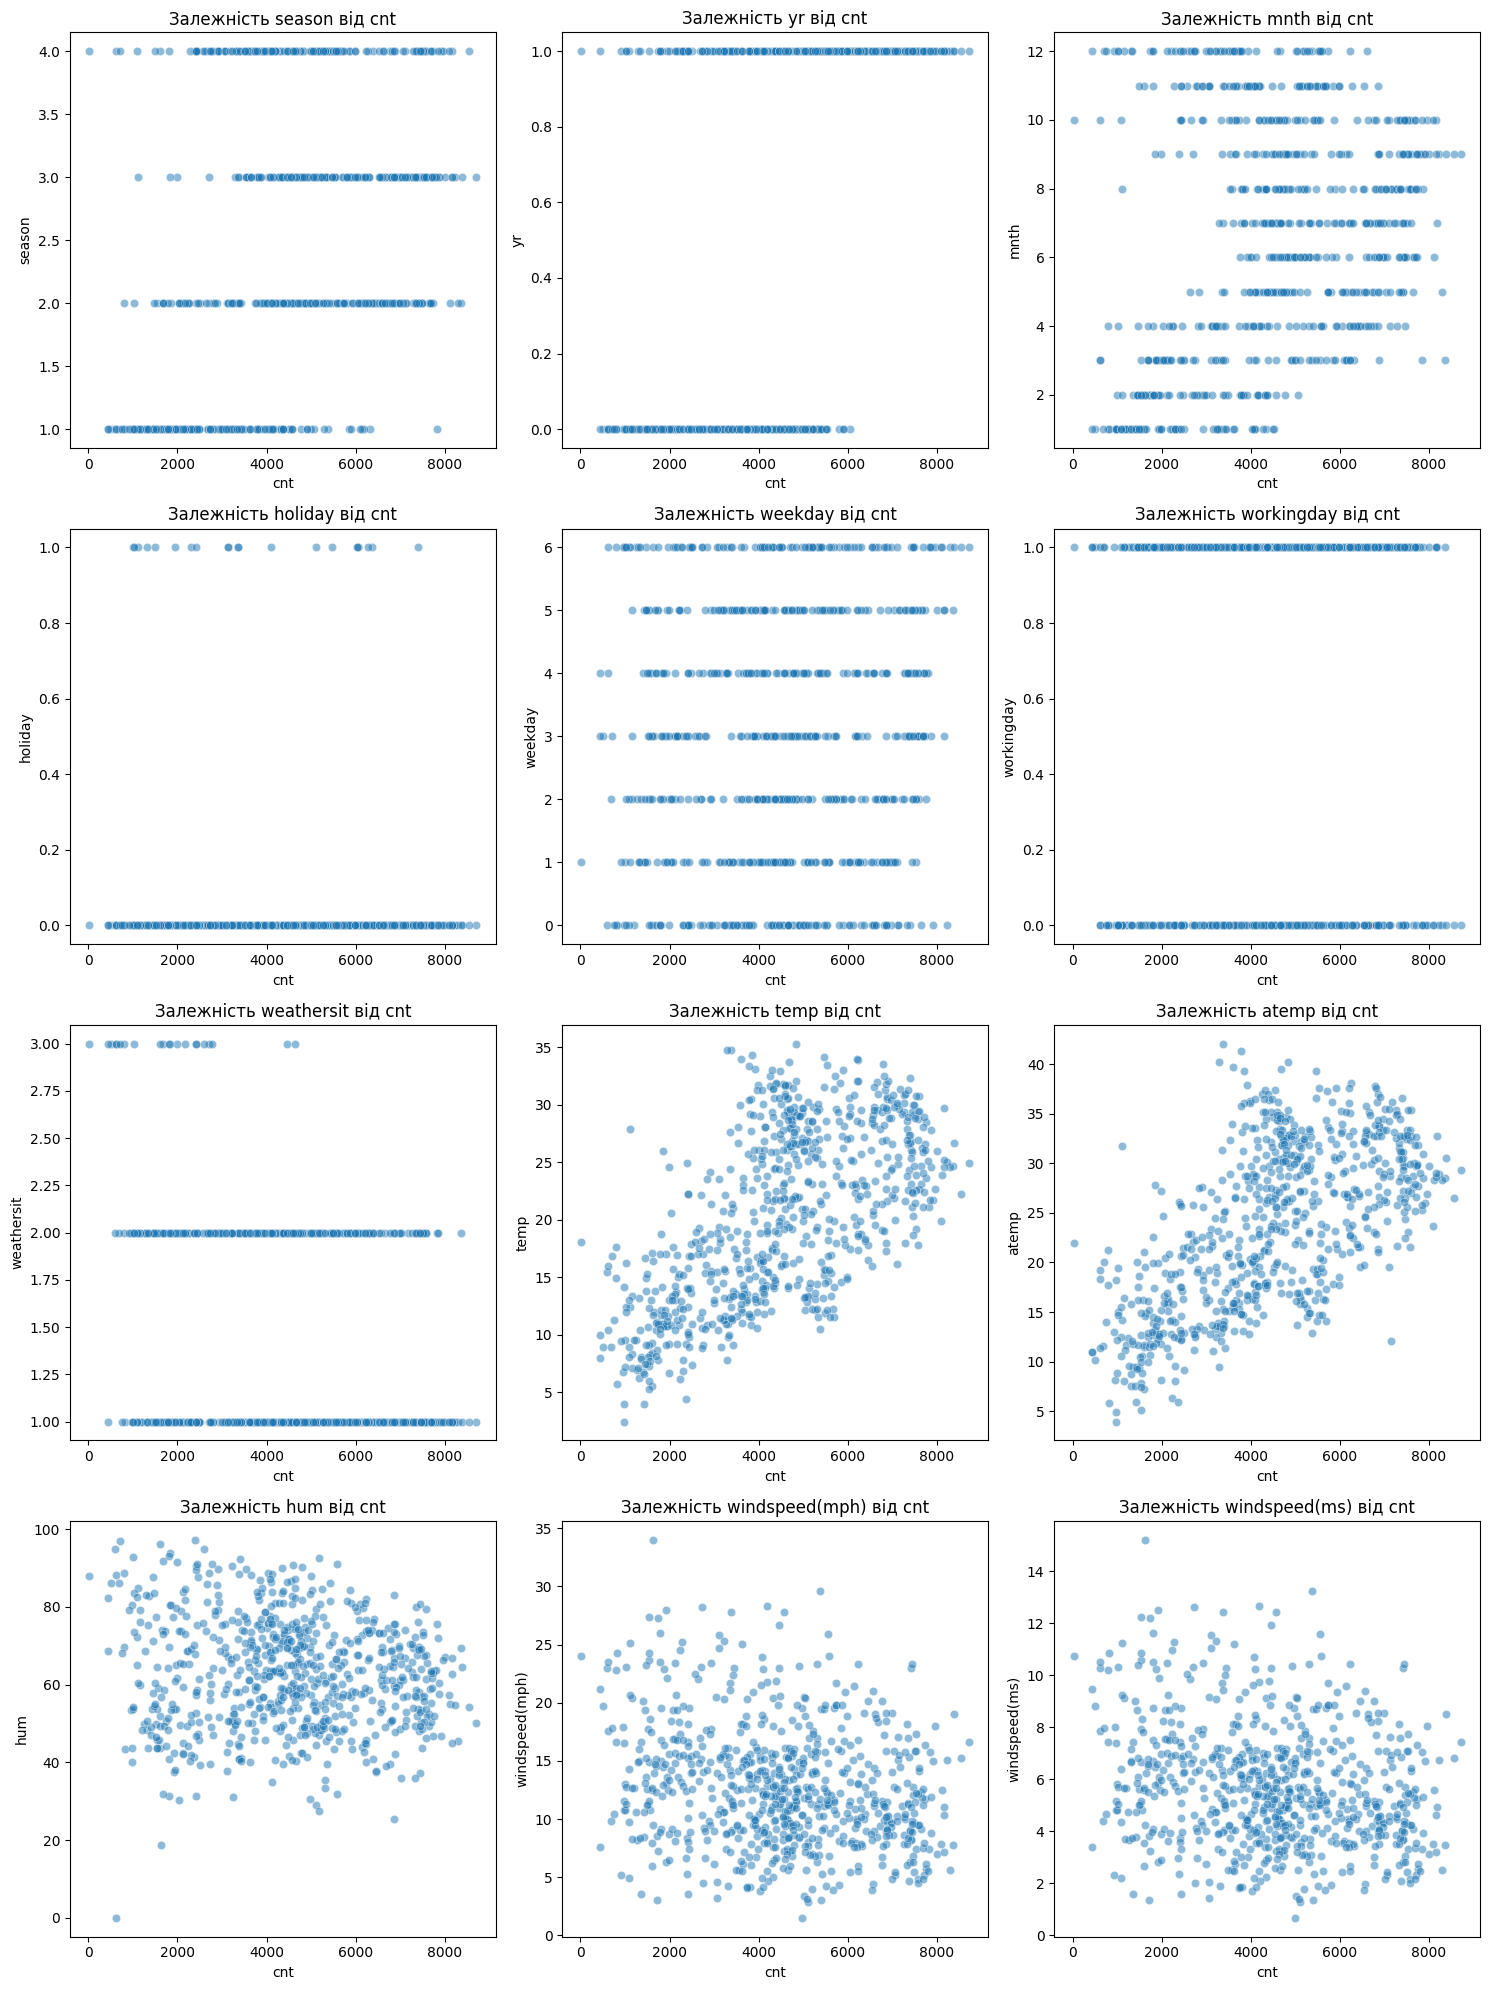

In [50]:
# Список атрибутів для аналізу
attributes = ["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit",
              "temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]

# Побудова графіків
plt.figure(figsize=(15, 20))
for i, attr in enumerate(attributes, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=df["cnt"], y=df[attr], alpha=0.5)
    plt.xlabel("cnt")
    plt.ylabel(attr)
    plt.title(f"Залежність {attr} від cnt")
plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця? Відповідь:

2. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

Відповідь:
1. Залежність нелінійна, а має вигляд сезонних коливань.

2. temp, atemp: чим вища температура, тим більше людей користується прокатом.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [51]:
correlations = df[attributes].corrwith(df["cnt"])
correlations

,0
season,0.406100
yr,0.566710
mnth,0.279977
holiday,-0.068348
weekday,0.067443
workingday,0.061156
weathersit,-0.297391
temp,0.627494
atemp,0.631066
hum,-0.100659


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [52]:
# Обчислюємо попарні кореляції між вибраними ознаками
selected_columns = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]
correlations = df[selected_columns].corr()
correlations
# матриця (таблиця) кореляцій для зазначених ознак, де кожен елемент матриці — це кореляція між двома змінними

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [53]:
# Обчислюємо середнє значення для кожної ознаки
mean_values = df[attributes].mean()
mean_values

,0
season,2.496580
yr,0.500684
mnth,6.519836
holiday,0.028728
weekday,2.997264
workingday,0.683995
weathersit,1.395349
temp,20.310776
atemp,23.717699
hum,62.789406


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [54]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [55]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [56]:
X[0]

array([ 1.354375  ,  0.99863295,  1.58866019, -0.171981  , -0.497782  ,
        0.67970582, -0.72604815, -0.10688374, -0.03254528,  0.74372737,
       -0.21121111, -0.21121111])

In [57]:
y

,cnt
703,6606
33,1550
300,3747
456,6041
633,7538
...,...
71,2417
106,3744
270,3907
435,4911


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [58]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [59]:
# Створюємо об'єкт лінійного регресора
model = LinearRegression()
# Навчаємо модель на всіх даних
model.fit(X, y)

# Виводимо пари (назва ознаки, вага)
weights = zip(df.columns[:-1], model.coef_)
for feature, weight in weights:
    print(f"{feature}: {weight}")

season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [60]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X, y)

# Виведення ваг
for feature, coef in zip(df.columns[:-1], lasso.coef_):
    print(f"{feature}: {coef}")

season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [61]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X, y)

# Виводимо коефіцієнти (ваги моделі)
for feature, coef in zip(df.columns[:-1], ridge.coef_):
    print(f"{feature}: {coef}")

season: 563.0645722520181
yr: 1018.9483787875305
mnth: -131.87332028247715
holiday: -86.74609799709232
weekday: 138.00511117871918
workingday: 55.90311037506467
weathersit: -332.34978849907367
temp: 386.45788919190807
atemp: 566.3470470600669
hum: -145.07132729867195
windspeed(mph): -99.25944108179067
windspeed(ms): -99.25944115434177


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [62]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    # Навчаємо Lasso-регресор
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    # Навчаємо Ridge-регресор
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

# Конвертуємо списки у np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Виводимо результати
print("Lasso Coefficients:\n", coefs_lasso)
print("Ridge Coefficients:\n", coefs_ridge)

Lasso Coefficients:
 [[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29892889e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41657943e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62789872e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

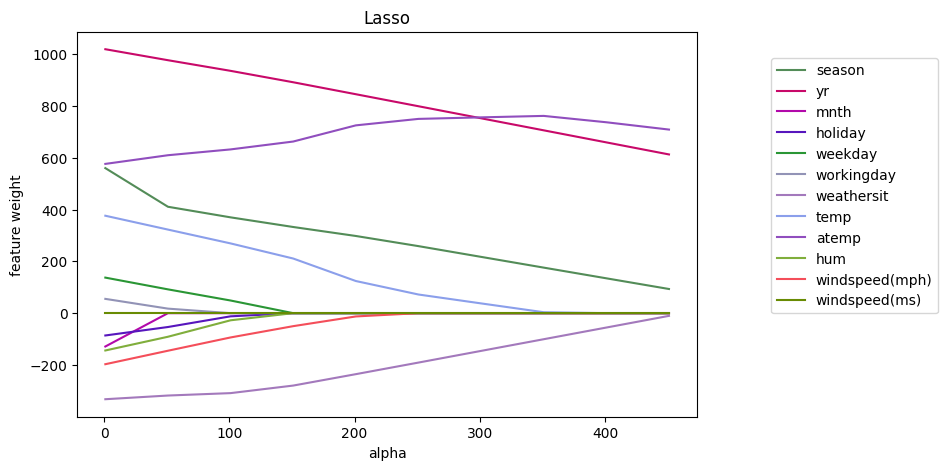

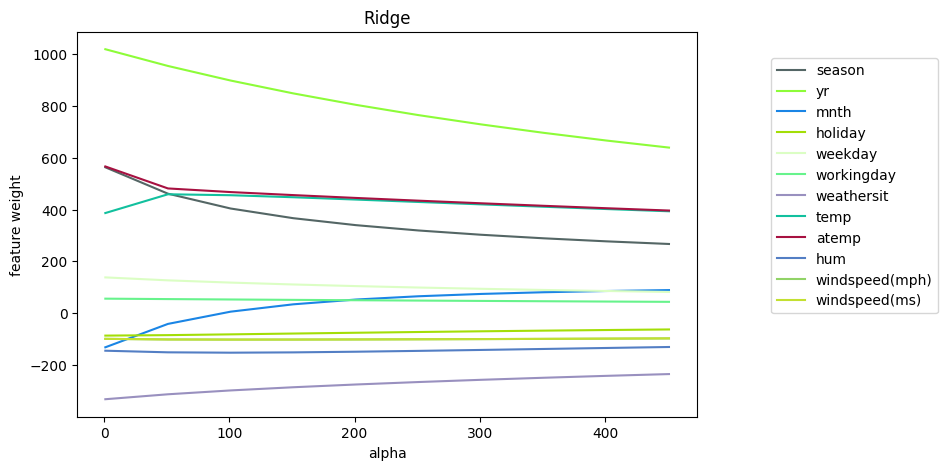

In [63]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

**Відповідь:**

1.
Lasso (L1-регуляризація) агресивніше занулює деякі коефіцієнти, що видно з рядів нульових значень у матриці коефіцієнтів.
Ridge (L2-регуляризація) натомість рівномірно зменшує всі коефіцієнти, але не занулює їх повністю.

2.
При дуже великому α всі ваги (окрім, можливо, кількох найважливіших) зануляться, і модель стане надмірно спрощеною (тобто прогноз буде базуватися лише на деяких змінних або взагалі на константі).

3.
Я НЕ ЗНАЮ ЩО ВІДПОВІСТИ

4.
Для відбору неінформативних ознак краще підходить Lasso-регресія (L1-регуляризація), оскільки вона може занулювати коефіцієнти при деяких ознаках, фактично виключаючи їх з моделі.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [64]:
# Функція для побудови графіка
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)  # Встановлюємо розмір графіка
    plt.figure(figsize=size)

    # Перетворюємо генератори на списки, щоб уникнути помилки
    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))

    plt.plot(x, y)  # Будуємо графік

    # Додаємо заголовок та підписи до осей
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()  # Додаємо сітку для кращої читабельності
    plt.show()  # Відображаємо графік

Оптимальне alpha: 6
Ознаки та коефіцієнти:
('season', 532.0189828413535)
('yr', 1015.0602226430595)
('mnth', -100.03952614356629)
('holiday', -83.29395987529904)
('weekday', 132.50446549095795)
('workingday', 51.557085614073735)
('weathersit', -330.5598567399817)
('temp', 370.67985503003405)
('atemp', 581.396931065498)
('hum', -140.00740550068844)
('windspeed(mph)', -191.77140847135036)
('windspeed(ms)', -2.6854702314758792e-08)
Матриця MSE під час крос-валідації:
[[830768.68693702 919721.93589263 805481.54522903]
 [822965.9041311  911867.54470864 804343.02766964]
 [815129.08593972 903855.55058088 803483.74706927]
 [807667.98224742 896148.95236924 802906.09265381]
 [800137.23263318 888747.72399201 801974.9311743 ]
 [793005.6616591  881651.8631318  800937.92121214]
 [786275.36724172 874861.36810104 799342.37031522]
 [779946.35004807 868376.23749144 798151.12777192]
 [774018.6100807  862196.47012638 797363.63293845]
 [768492.14733962 856322.06502308 796979.89551936]
 [763366.96182482 850

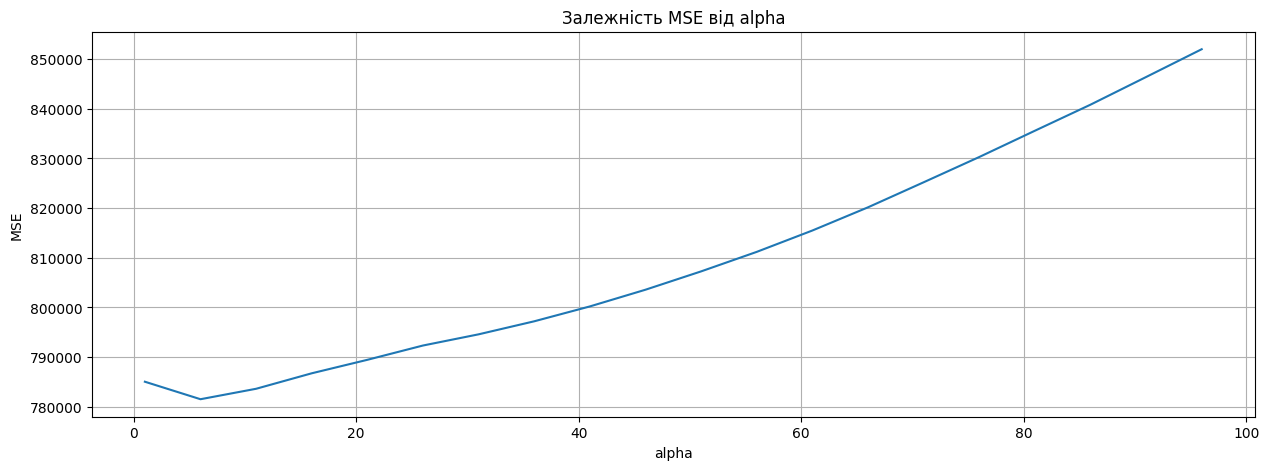

In [65]:
from sklearn.linear_model import LassoCV

# Генеруємо значення alpha (параметра регуляризації) в діапазоні від 1 до 100 із кроком 5
alphas = np.arange(1, 100, 5)

# Створюємо модель LassoCV, яка підбирає найкраще alpha за допомогою крос-валідації
regressor = LassoCV(alphas=alphas, cv=3)  # cv=3 означає 3-фолд крос-валідацію

# Навчаємо модель на тренувальних даних X (матриця ознак) та y (цільова змінна)
regressor.fit(X, y)

# Виводимо оптимальне значення alpha, яке підібрала модель
print("Оптимальне alpha:", regressor.alpha_)

# Виводимо список ознак і відповідні їм коефіцієнти
print("Ознаки та коефіцієнти:")
w = zip(df.columns, regressor.coef_)  # Створюємо пари (назва ознаки, її ваговий коефіцієнт)
for z in w:
    print(z)

# Виводимо MSE (Mean Squared Error) для кожного alpha у процесі крос-валідації
print("Матриця MSE під час крос-валідації:")
print(regressor.mse_path_)

# Будуємо графік залежності середнього MSE від alpha
create_plot(
    list(zip(regressor.alphas_, regressor.mse_path_.mean(axis=1))),  # Перетворюємо zip у список
    "Залежність MSE від alpha",  # Заголовок графіка
    "alpha",  # Назва осі X
    "MSE"  # Назва осі Y
)

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

**Мої висновки:**

- Найважливіші змінні: yr, season, atemp, temp, weathersit.
- Менш значущі змінні: holiday, workingday, windspeed(ms), яка фактично занулена.
- Lasso допомогло відкинути слабкі змінні, що зробило модель більш інтерпретованою.
- Оптимальне alpha = 6 вибране, оскільки воно дає найкращий баланс між точністю та регуляризацією.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Значення alpha, що дають мінімум MSE для кожного розбиття (крос-валідації):
[6, 1, 51]


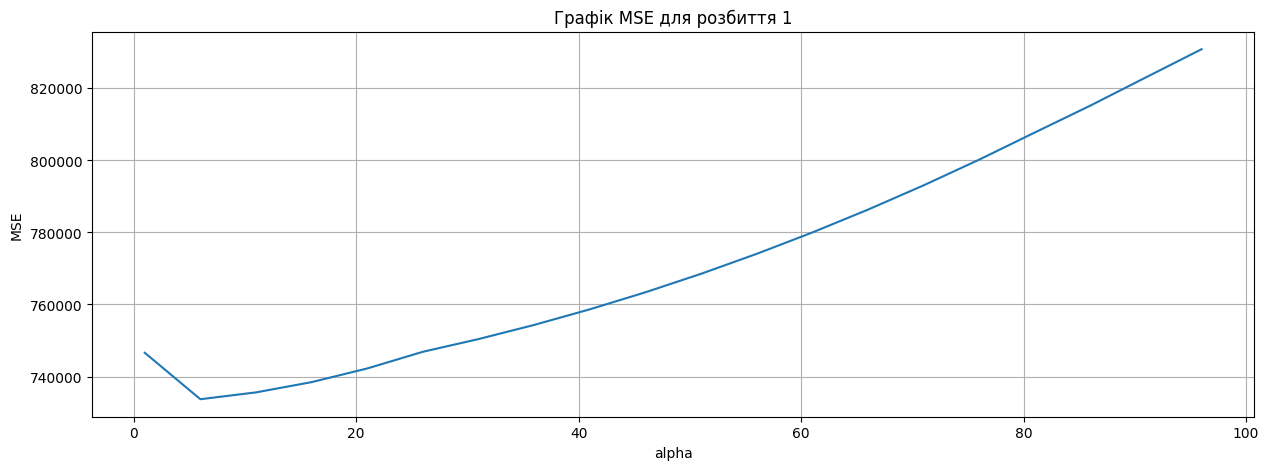

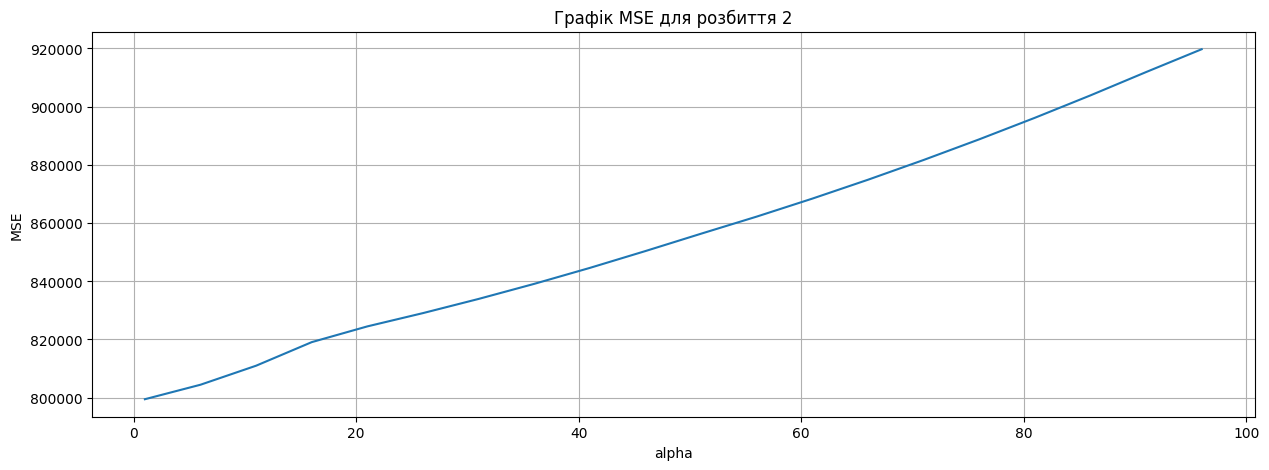

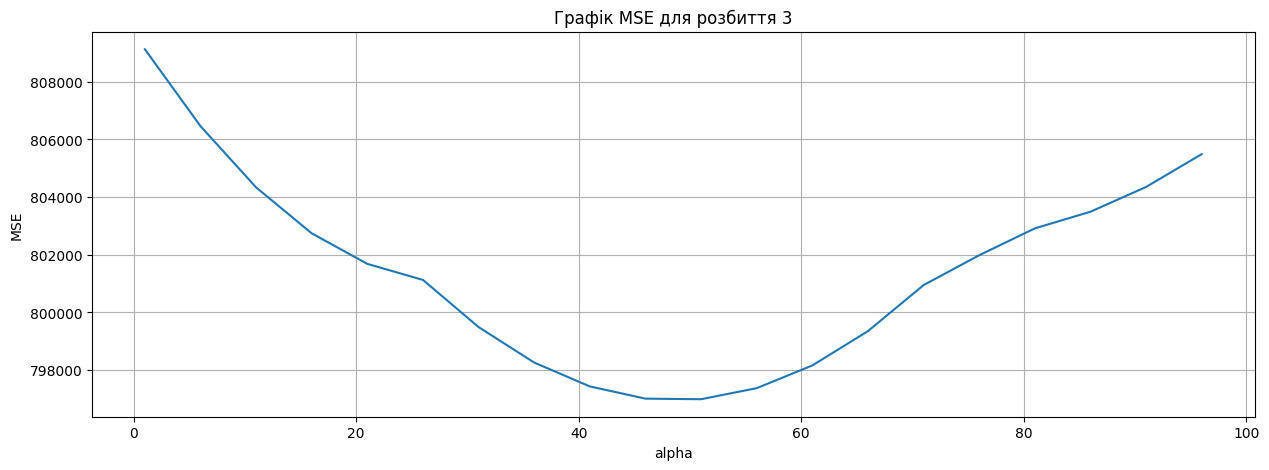

In [66]:
# Знаходимо alpha для кожного розбиття (стовпця), яке дає мінімум MSE
min_alpha_for_each_fold = [regressor.alphas_[np.argmin(regressor.mse_path_[:, i])] for i in range(regressor.mse_path_.shape[1])]

# Виводимо значення alpha, що дають мінімум MSE на кожному розбитті
print("Значення alpha, що дають мінімум MSE для кожного розбиття (крос-валідації):")
print(min_alpha_for_each_fold)

# Створюємо три окремі графіки для кожного стовпця MSE
for i in range(3):
    create_plot(
        list(zip(regressor.alphas_, regressor.mse_path_[:, i])),  # Вибираємо стовпець для кожного графіка
        f"Графік MSE для розбиття {i+1}",
        "alpha",  # Назва осі X
        "MSE"  # Назва осі Y
    )

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [67]:
# Створюємо масив ознак та їхніх коефіцієнтів
features_coefficients = np.array(list(zip(df.columns, regressor.coef_)))

# Відсортовуємо за значенням коефіцієнта у спадаючому порядку
sorted_features = sorted(features_coefficients, key=lambda x: float(x[1]), reverse=True)

# Беремо перші 4 ознаки
top_4_features = sorted_features[:4]

# Виводимо результат
print("Чотири ознаки з найбільшими позитивними коефіцієнтами:")
for feature, coef in top_4_features:
    print(f"{feature}: {coef}")

Чотири ознаки з найбільшими позитивними коефіцієнтами:
yr: 1015.0602226430595
atemp: 581.396931065498
season: 532.0189828413535
temp: 370.67985503003405


**Відповіді:**

- В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми зображали у блоці "Ознайомлення з даними".

Чотири ознаки з найбільшими позитивними коефіцієнтами:
yr: 1015.0602226430595
atemp: 581.396931065498
season: 532.0189828413535
temp: 370.67985503003405

- Чи видно зростаючу лінійну залежність cnt від цих ознак за графіками? yr - так, atemp - так, season - середньо, temp - так

- Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Так, логічно стверджувати, що зі збільшенням значень цих ознак кількість оренд велосипедів зростає.
- yr (рік) – так, оскільки з кожним роком популярність сервісу зростає, і кількість користувачів збільшується.
- atemp (відчутна температура) – так, комфортніші погодні умови сприяють активнішому використанню велосипедів.
- season (сезон) – середньо, бо різні сезони впливають на попит нерівномірно (влітку більше, взимку менше).
- temp (температура повітря) – так, адже тепла погода сприяє катанню, але є межа, коли надмірна спека може зменшити попит.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [68]:
# Створюємо масив ознак та їхніх коефіцієнтів
features_coefficients = np.array(list(zip(df.columns, regressor.coef_)))

# Відсортовуємо за значенням коефіцієнта у спадаючому порядку
sorted_features = sorted(features_coefficients, key=lambda x: float(x[1]), reverse=False)

# Беремо перші 4 ознаки
top_4_features = sorted_features[:4]

# Виводимо результат
print("Чотири ознаки з найбільшими за модулем негативними коефіцієнтами:")
for feature, coef in top_4_features:
    print(f"{feature}: {coef}")

Чотири ознаки з найбільшими за модулем негативними коефіцієнтами:
weathersit: -330.5598567399817
windspeed(mph): -191.77140847135036
hum: -140.00740550068844
mnth: -100.03952614356629


- Чи видно лінійну залежність, що зменшується? - так

- Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди? - так

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [69]:
# Створюємо масив ознак та їхніх коефіцієнтів
features_coefficients = np.array(list(zip(df.columns, regressor.coef_)))

# Встановлюємо поріг для коефіцієнтів близьких до нуля
threshold = 1e-3

# Фільтруємо ознаки з коефіцієнтами, близькими до нуля
near_zero_features = [(feature, coef) for feature, coef in features_coefficients if abs(float(coef)) < threshold]

# Виводимо результат
print("Ознаки з коефіцієнтами, близькими до нуля:")
for feature, coef in near_zero_features:
    print(f"{feature}: {coef}")

Ознаки з коефіцієнтами, близькими до нуля:
windspeed(ms): -2.6854702314758792e-08


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.